In [1]:
import tensorflow as tf
print(f"TensorFlow ver: {tf.__version__}")
print(f"GPU able: {tf.config.list_physical_devices('GPU')}")

TensorFlow ver: 2.10.1
GPU able: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os, json, math, random
import numpy as np
import pandas as pd

In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [4]:
X_ai = np.load("train_ai.npy")
X_human = np.load("train_human.npy")
print(X_ai.shape, X_human.shape)

(8161, 100, 768) (8161, 100, 768)


In [5]:
df_val = pd.read_json("validation.jsonl", lines=True)

X_val_list, y_val_list, val_id_list = [], [], []
for row in df_val.itertuples():
    arr = np.array(row.features, dtype=np.float32)   # (N_i,100,768)
    for sub in arr:  # sub is slice for each id: (100,768)
        X_val_list.append(sub)
        y_val_list.append(row.label)
        val_id_list.append(row.id)

X_val = np.stack(X_val_list)
y_val = np.array(y_val_list)
val_ids = np.array(val_id_list)

print(X_val.shape, y_val.shape, val_ids.shape, len(np.unique(val_ids)))

(220, 100, 768) (220,) (220,) 20


In [6]:
df_test = pd.read_json("test_features.jsonl", lines=True)

X_test_list, test_id_list = [], []
for row in df_test.itertuples():
    arr = np.array(row.features, dtype=np.float32)
    for sub in arr:
        X_test_list.append(sub)
        test_id_list.append(row.id)

X_test = np.stack(X_test_list)
test_ids = np.array(test_id_list)

print(X_test.shape, test_ids.shape, len(np.unique(test_ids)))

(1686, 100, 768) (1686,) 180


In [7]:
from sklearn.utils import shuffle

y_ai = np.ones(len(X_ai),  dtype=np.int32)
y_human = np.zeros(len(X_human), dtype=np.int32)

X_train = np.concatenate([X_ai, X_human], axis=0)
y_train = np.concatenate([y_ai, y_human], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=SEED)

print(X_train.shape, y_train.shape)

(16322, 100, 768) (16322,)


In [8]:
inp = tf.keras.Input(shape=(100,768))
x = tf.keras.layers.Masking(mask_value=0.0)(inp)
x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.0)
)(x)
x = tf.keras.layers.Attention()([x, x])
x = tf.keras.layers.GlobalAveragePooling1D()(x)

x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
out = tf.keras.layers.Dense(1, activation="sigmoid", dtype="float32")(x)
bigru_light = tf.keras.Model(inp, out)
bigru_light.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(curve="ROC", name="auroc")]
)

bigru_light.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 768)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 100, 768)     0           ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 100, 256)     689664      ['masking[0][0]']                
                                                                                                  
 attention (Attention)          (None, 100, 256)     0           ['bidirectional[0][0]',          
                                                                  'bidirectional[0][0]']      

In [9]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_auroc", mode="max", patience=2,
    restore_best_weights=True, verbose=1
)

In [ ]:
with tf.device("/CPU:0"):
    history = bigru_light.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=20,
        batch_size=32,
        callbacks=[es],
        verbose=1
    )
    
    

Epoch 1/20
460/460 [==============================] - 402s 864ms/step - loss: 0.3857 - auroc: 0.9071 - val_loss: 0.5227 - val_auroc: 0.9559
Epoch 2/20
460/460 [==============================] - 282s 613ms/step - loss: 0.3215 - auroc: 0.9368 - val_loss: 0.3401 - val_auroc: 0.9574
Epoch 3/20
460/460 [==============================] - 274s 596ms/step - loss: 0.2810 - auroc: 0.9518 - val_loss: 0.3086 - val_auroc: 0.9595
Epoch 4/20
460/460 [==============================] - 259s 563ms/step - loss: 0.2744 - auroc: 0.9540 - val_loss: 0.2740 - val_auroc: 0.9626
Epoch 5/20
460/460 [==============================] - 263s 573ms/step - loss: 0.2604 - auroc: 0.9586 - val_loss: 0.2453 - val_auroc: 0.9641
Epoch 6/20
460/460 [==============================] - 261s 568ms/step - loss: 0.2602 - auroc: 0.9585 - val_loss: 0.2643 - val_auroc: 0.9631
Epoch 7/20
460/460 [==============================] - 263s 573ms/step - loss: 0.2554 - auroc: 0.9602 - val_loss: 0.2374 - val_auroc: 0.9662
Epoch 8/20
460/460 [

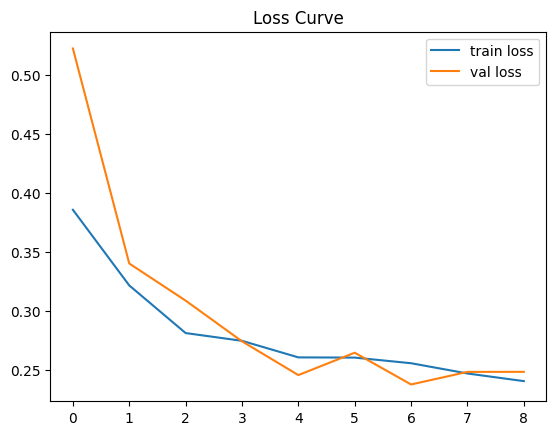

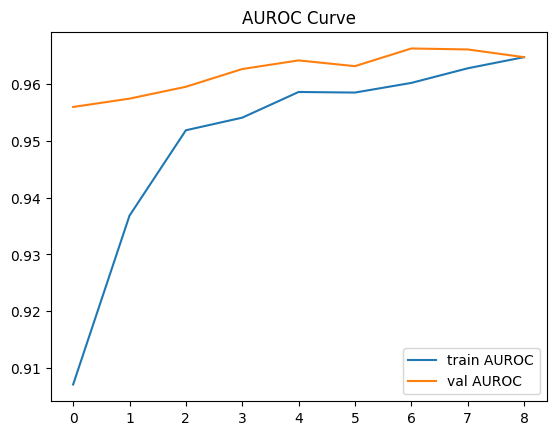

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend(); plt.title("Loss Curve"); plt.show()

plt.plot(history.history["auroc"], label="train AUROC")
plt.plot(history.history["val_auroc"], label="val AUROC")
plt.legend(); plt.title("AUROC Curve"); plt.show()

In [12]:
from sklearn.metrics import roc_auc_score, classification_report

y_val_prob = bigru_light.predict(X_val).ravel()
val_auc = roc_auc_score(y_val, y_val_prob)
print("Validation AUROC:", val_auc)

7/7 [==============================] - 7s 48ms/step
Validation AUROC: 0.765540994623656


In [13]:
y_val_pred = (y_val_prob > 0.5).astype(int)
print(classification_report(y_val, y_val_pred, digits=3))

              precision    recall  f1-score   support

           0      0.687     0.831     0.752       124
           1      0.700     0.510     0.590        96

    accuracy                          0.691       220
   macro avg      0.693     0.671     0.671       220
weighted avg      0.692     0.691     0.681       220



In [14]:
def eval_doc_level(probs, labels, ids, agg="mean"):
    doc_probs = {}
    doc_labels = {}
    for p, y, i in zip(probs, labels, ids):
        doc_probs.setdefault(i, []).append(p)
        doc_labels[i] = y
    # 聚合
    if agg == "mean":
        doc_probs = {i: np.mean(v) for i,v in doc_probs.items()}
    elif agg == "max":
        doc_probs = {i: np.max(v) for i,v in doc_probs.items()}
    elif agg == "vote":
        doc_probs = {i: (np.mean(v) > 0.5).astype(float) for i,v in doc_probs.items()}

    probs = np.array(list(doc_probs.values()))
    labels = np.array(list(doc_labels.values()))
    auc = roc_auc_score(labels, probs)
    return auc, probs, labels

In [15]:
val_auc_doc, doc_probs, doc_labels = eval_doc_level(y_val_prob, y_val, val_ids, agg="mean")
print("Validation AUROC (doc-level):", val_auc_doc)

Validation AUROC (doc-level): 0.9100000000000001


In [16]:
inp = tf.keras.Input(shape=(100,768))
x = tf.keras.layers.Masking(mask_value=0.0)(inp)

c3 = tf.keras.layers.Conv1D(256, 3, padding="same", activation="relu")(x)
c5 = tf.keras.layers.Conv1D(256, 5, padding="same", activation="relu")(x)
c7 = tf.keras.layers.Conv1D(256, 7, padding="same", activation="relu")(x)

p = tf.keras.layers.concatenate([
    tf.keras.layers.GlobalMaxPool1D()(c3),
    tf.keras.layers.GlobalMaxPool1D()(c5),
    tf.keras.layers.GlobalMaxPool1D()(c7),
])

p = tf.keras.layers.Dense(128, activation="relu")(p)
p = tf.keras.layers.Dropout(0.3)(p)
out = tf.keras.layers.Dense(1, activation="sigmoid", dtype="float32")(p)

textcnn_light = tf.keras.Model(inp, out)
textcnn_light.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(curve="ROC", name="auroc")]
)

textcnn_light.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 768)]   0           []                               
                                                                                                  
 masking_1 (Masking)            (None, 100, 768)     0           ['input_2[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 100, 256)     590080      ['masking_1[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 100, 256)     983296      ['masking_1[0][0]']              
                                                                                            

In [17]:
with tf.device("/CPU:0"):
    history_cnn = textcnn_light.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=20,
        batch_size=16,
        callbacks=[es],
        verbose=1
    )

Epoch 1/20
919/919 [==============================] - 142s 154ms/step - loss: 0.4135 - auroc: 0.8949 - val_loss: 0.3041 - val_auroc: 0.9496
Epoch 2/20
919/919 [==============================] - 140s 153ms/step - loss: 0.3006 - auroc: 0.9456 - val_loss: 0.2729 - val_auroc: 0.9589
Epoch 3/20
919/919 [==============================] - 135s 147ms/step - loss: 0.2677 - auroc: 0.9564 - val_loss: 0.2642 - val_auroc: 0.9664
Epoch 4/20
919/919 [==============================] - 137s 149ms/step - loss: 0.2574 - auroc: 0.9597 - val_loss: 0.2433 - val_auroc: 0.9640
Epoch 5/20
919/919 [==============================] - 137s 149ms/step - loss: 0.2387 - auroc: 0.9654 - val_loss: 0.2419 - val_auroc: 0.9685
Epoch 6/20
919/919 [==============================] - 139s 151ms/step - loss: 0.2297 - auroc: 0.9674 - val_loss: 0.2221 - val_auroc: 0.9702
Epoch 7/20
919/919 [==============================] - 136s 148ms/step - loss: 0.2249 - auroc: 0.9691 - val_loss: 0.2822 - val_auroc: 0.9663
Epoch 8/20
919/919 [

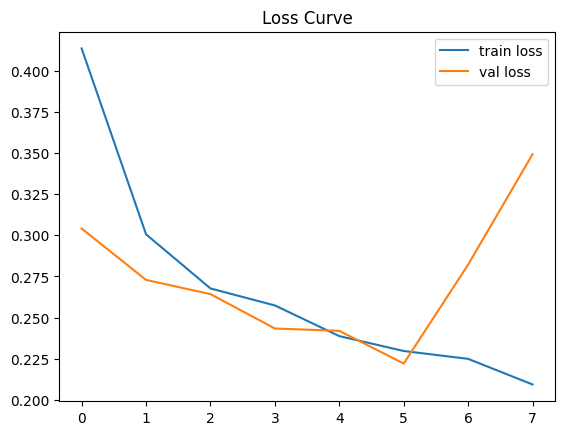

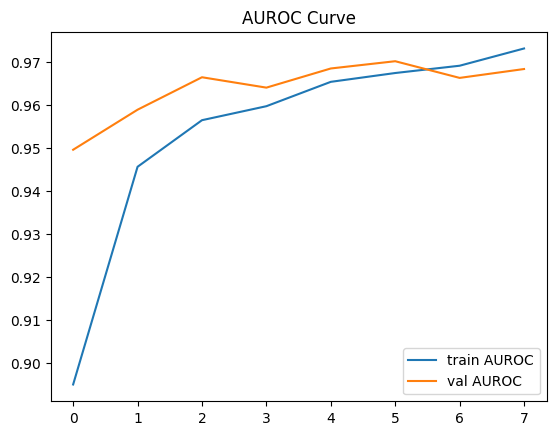

In [18]:
plt.plot(history_cnn.history["loss"], label="train loss")
plt.plot(history_cnn.history["val_loss"], label="val loss")
plt.legend(); plt.title("Loss Curve"); plt.show()

plt.plot(history_cnn.history["auroc"], label="train AUROC")
plt.plot(history_cnn.history["val_auroc"], label="val AUROC")
plt.legend(); plt.title("AUROC Curve"); plt.show()

In [19]:
y_val_prob_cnn = textcnn_light.predict(X_val).ravel()

7/7 [==============================] - 4s 62ms/step


In [20]:
val_auc_cnn = roc_auc_score(y_val, y_val_prob_cnn)
print("Validation AUROC:", val_auc_cnn)

Validation AUROC: 0.7883904569892473


In [21]:
y_val_preb_cnn = (y_val_prob_cnn > 0.5).astype(int)
print(classification_report(y_val, y_val_preb_cnn, digits=3))

              precision    recall  f1-score   support

           0      0.686     0.879     0.770       124
           1      0.754     0.479     0.586        96

    accuracy                          0.705       220
   macro avg      0.720     0.679     0.678       220
weighted avg      0.715     0.705     0.690       220



In [22]:
val_auc_doc_cnn, doc_probs_cnn, doc_labels_cnn = eval_doc_level(y_val_prob_cnn, y_val, val_ids, agg="mean")
print("Validation AUROC (doc-level):", val_auc_doc_cnn)

Validation AUROC (doc-level): 0.9400000000000001


In [23]:
y_test_prob_gru = bigru_light.predict(X_test).ravel()
df_probs_gru = pd.DataFrame({'id': test_ids, 'prob': y_test_prob_gru})
final_probs_gru = df_probs_gru.groupby('id')['prob'].mean().reset_index()
print(final_probs_gru.head())

53/53 [==============================] - 1s 17ms/step
   id      prob
0  15  0.112023
1  16  0.166302
2  17  0.078385
3  18  0.413398
4  19  0.248434


In [24]:
final_probs_gru.to_csv("final_probs_gru_20ep.csv", index=False)

In [25]:
bigru_light.save("bigru_light_20ep.keras")

In [26]:
y_test_prob_cnn = textcnn_light.predict(X_test).ravel()
df_probs_cnn = pd.DataFrame({'id': test_ids, 'prob': y_test_prob_cnn})
final_probs_cnn = df_probs_cnn.groupby('id')['prob'].mean().reset_index()
print(final_probs_cnn.head())

53/53 [==============================] - 2s 44ms/step
   id      prob
0  15  0.066916
1  16  0.147923
2  17  0.048348
3  18  0.418261
4  19  0.155254


In [27]:
final_probs_cnn.to_csv("final_probs_cnn_20ep.csv", index=False)

In [28]:
textcnn_light.save("textcnn_light_20ep.keras")